## Multi-Class Classification Problem

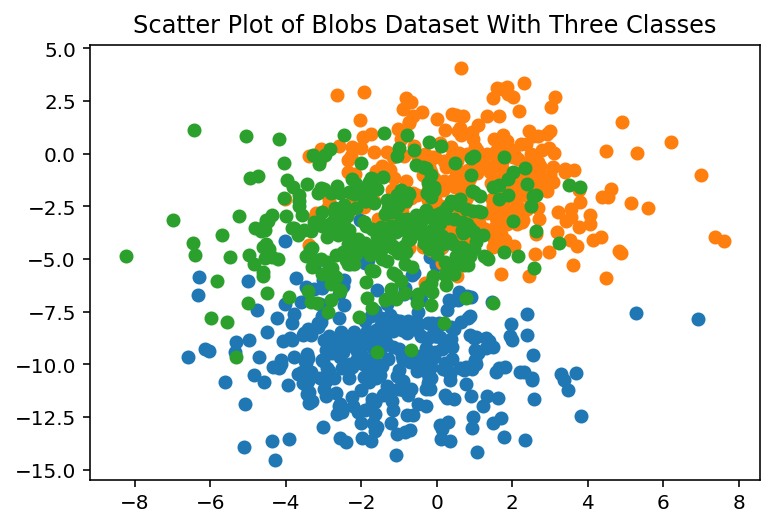

In [1]:
# Scatter plot of blobs dataset
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Generat 2d classification dataset
X, y = make_blobs(
    n_samples=1000, 
    centers=3, 
    n_features=2, 
    cluster_std=2, 
    random_state=2
    )

# Scatter plot for each class value
for class_value in range(3):
    # Select indices of points with the class label
    row_ix = np.where(y==class_value)
    # Scatter plot for points with a dirrent color
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

plt.title('Scatter Plot of Blobs Dataset With Three Classes')
plt.show()

## Supervised Greedy Layer-Wise Pretraining

> layers=2, train=0.834, test=0.820
> layers=3, train=0.824, test=0.822
> layers=4, train=0.844, test=0.828
> layers=5, train=0.842, test=0.826
> layers=6, train=0.842, test=0.834
> layers=7, train=0.834, test=0.828
> layers=8, train=0.830, test=0.838
> layers=9, train=0.830, test=0.834
> layers=10, train=0.830, test=0.830
> layers=11, train=0.832, test=0.828
> layers=12, train=0.836, test=0.830


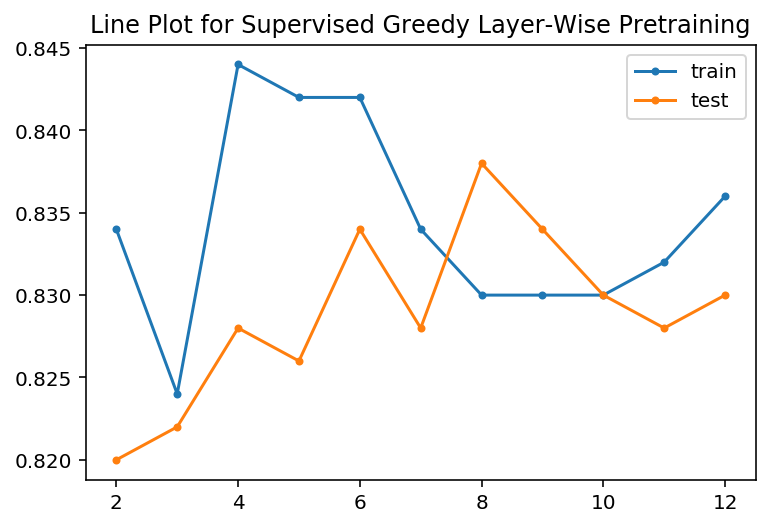

In [10]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

def prepare_dataset():
    # Generat 2d classification dataset
    X, y = make_blobs(
        n_samples=1000, 
        centers=3, 
        n_features=2, 
        cluster_std=2, 
        random_state=2
        )
    y = to_categorical(y)
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train, :], y[n_train:, :]
    return X_train, X_test, y_train, y_test

# Define and fit the base model
def get_base_model(X_train, y_train):
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, verbose=0)
    return model

def add_layer(model, X_train, y_train):
    # Remember the current output layer
    output_layer = model.layers[-1]
    # Remove the output layer
    model.pop()
    # Mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # Add a new hidden layer
    model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    # Re-add the output layer
    model.add(output_layer)
    model.fit(X_train, y_train, epochs=100, verbose=0)
    return model

def evaluate_model(model, X_train, X_test, y_train, y_test):
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    return train_acc, test_acc


X_train, X_test, y_train, y_test = prepare_dataset()
model = get_base_model(X_train, y_train)
scores = dict()
train_acc, test_acc = evaluate_model(model, X_train, X_test, y_train, y_test)
print('> layers={0}, train={1:.3f}, test={2:.3f}'.format(len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)

# Add layers and evaluate the updated model
n_layers = 10
for i in range(n_layers):
    model = add_layer(model, X_train, y_train)
    train_acc, test_acc = evaluate_model(model, X_train, X_test, y_train, y_test)
    print('> layers={0}, train={1:.3f}, test={2:.3f}'.format(len(model.layers), train_acc, test_acc))
    scores[len(model.layers)] = (train_acc, test_acc)

# Plot the number of added layers vs. accuracy
plt.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
plt.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
plt.legend()
plt.title('Line Plot for Supervised Greedy Layer-Wise Pretraining')
plt.show()

## Unsupervised Greedy Layer-Wise Pretraining


> reconstruction error train=0.000, test=0.000
> classifier accuracy layers=2, train=0.832, test=0.830
> reconstruction error train=0.001, test=0.002
> classifier accuracy layers=3, train=0.828, test=0.830
> reconstruction error train=0.001, test=0.002
> classifier accuracy layers=4, train=0.824, test=0.840
> reconstruction error train=0.002, test=0.004
> classifier accuracy layers=5, train=0.804, test=0.834
> reconstruction error train=0.032, test=0.045
> classifier accuracy layers=6, train=0.788, test=0.808
> reconstruction error train=10.409, test=10.663
> classifier accuracy layers=7, train=0.342, test=0.326


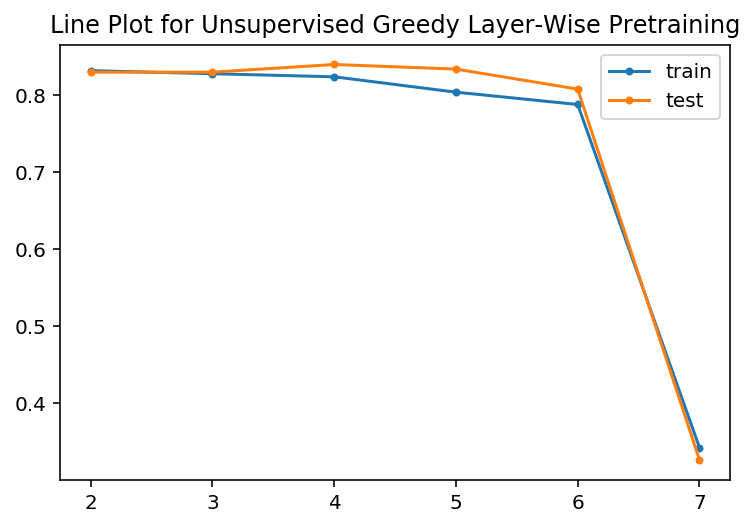

In [12]:
# Define, fit, and evaluate the base autoencoder
def base_autoencoder(X_train, X_test):
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='linear'))
    model.compile(
        loss='mse',
        optimizer=SGD(lr=0.01, momentum=0.9))
    model.fit(X_train, X_train, epochs=100, verbose=0)
    # Evaluate reconstruction loss
    train_mse = model.evaluate(X_train, X_train, verbose=0)
    test_mse = model.evaluate(X_test, X_test, verbose=0)
    print('> reconstruction error train={0:.3f}, test={1:.3f}'.format(train_mse, test_mse))
    return model

def evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test):
    # Remember the current output layer
    output_layer = model.layers[-1]
    # Remove the output layer
    model.pop()
    # Mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # Add new output layer
    model.add(Dense(3, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, verbose=0)
    # Evaluate model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    # Put the model back together
    model.pop()
    model.add(output_layer)
    model.compile(
        loss='mse',
        optimizer=SGD(lr=0.01, momentum=0.9))
    return train_acc, test_acc

# Add oen new layer and re-trian only the new layer
def add_layer_to_autoencoder(model, X_train, X_test):
    # Remember the current output layer
    output_layer = model.layers[-1]
    # Remove the output layer
    model.pop()
    # Mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # Add a new hidden layer
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    # Re-add the output layer
    model.add(output_layer)
    model.fit(X_train, X_train, epochs=100, verbose=0)
    train_mse = model.evaluate(X_train, X_train, verbose=0)
    test_mse = model.evaluate(X_test, X_test, verbose=0)
    print('> reconstruction error train={0:.3f}, test={1:.3f}'.format(train_mse, test_mse))
    return model


X_train, X_test, y_train, y_test = prepare_dataset()
# Evaluate the base model
model = base_autoencoder(X_train, X_test)
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test)
print('> classifier accuracy layers={0}, train={1:.3f}, test={2:.3f}'.format(len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)

# Add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
    model = add_layer_to_autoencoder(model, X_train, X_test)
    train_acc, test_acc = evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test)
    print('> classifier accuracy layers={0}, train={1:.3f}, test={2:.3f}'.format(len(model.layers), train_acc, test_acc))
    scores[len(model.layers)] = (train_acc, test_acc)

# Plot number of added layers vs. accuracy
plt.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
plt.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
plt.legend()
plt.title('Line Plot for Unsupervised Greedy Layer-Wise Pretraining')
plt.show()